In [22]:
# # Lưu ý: chạy trong môi trường có pip (Windows/Linux/Mac)
# # pip install yfinance pandas

# import yfinance as yf
# import pandas as pd

# ticker = "VCB.VN"
# start_date = "2022-01-01"
# end_date = "2025-09-11"   # để bao gồm 10-09-2025, end là exclusive trong một số API -> dùng 1 ngày tiếp theo

# # tải dữ liệu hàng ngày
# df = yf.download(ticker, start=start_date, end=end_date, progress=False)

# # kiểm tra vài dòng
# print(df.head())
# print(df.tail())

# # lưu CSV
# out_path = "VCB_2022_to_2025-09-10.csv"
# df.to_csv(out_path, index=True)
# print(f"Saved: {out_path}")

In [23]:
# import yfinance as yf
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf

# # 1. Tải dữ liệu VCB từ 2022 đến nay
# df = yf.download("VCB.VN", start="2022-01-01", end="2025-09-11", progress=False)

---

# 1. Xử lý dữ liệu

In [24]:
df = pd.read_csv('VCB_2022_to_2025-09-10.csv')
df.head()

,Date,Close,High,Low,Open,Volume
0,4/01/2022,44744.12500,44970.67578,44177.74219,44744.12500,2001830
1,5/01/2022,44177.74219,45537.05859,44177.74219,44744.12500,2987563
2,6/01/2022,44800.76172,45253.86719,44121.10547,44517.57031,2146256
3,7/01/2022,45197.22656,45253.86719,44291.01953,45083.95313,1705917
4,10/01/2022,45027.31250,45253.86719,44460.93359,45140.58984,2041027


In [25]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
print(df['Date'].dtype)

datetime64[ns]


In [26]:
df.set_index('Date', inplace=True)

In [27]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-04,44744.12500,44970.67578,44177.74219,44744.12500,2001830
2022-01-05,44177.74219,45537.05859,44177.74219,44744.12500,2987563
2022-01-06,44800.76172,45253.86719,44121.10547,44517.57031,2146256
2022-01-07,45197.22656,45253.86719,44291.01953,45083.95313,1705917
2022-01-10,45027.31250,45253.86719,44460.93359,45140.58984,2041027


---

#2. Bắt đầu

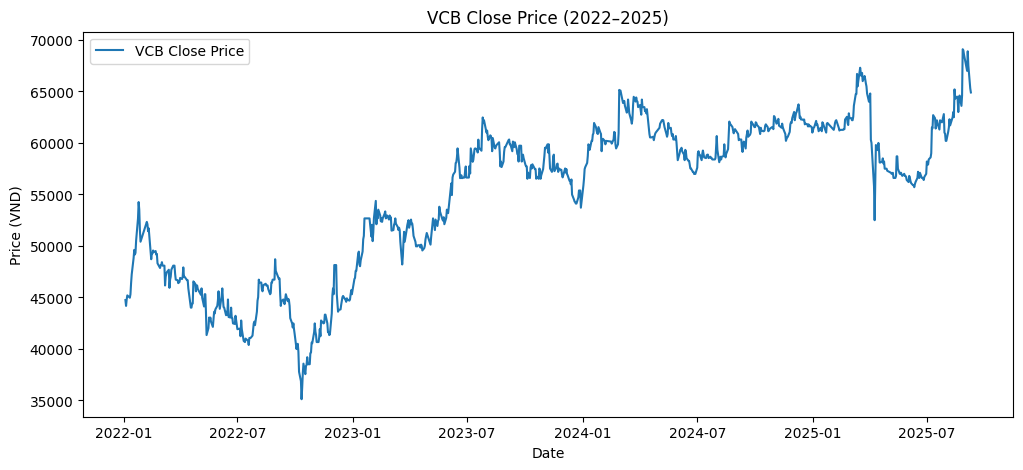

In [28]:
# 3. Vẽ dữ liệu thô
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label="VCB Close Price")
plt.title("VCB Close Price (2022–2025)")
plt.xlabel("Date")
plt.ylabel("Price (VND)")
plt.legend()
plt.show()

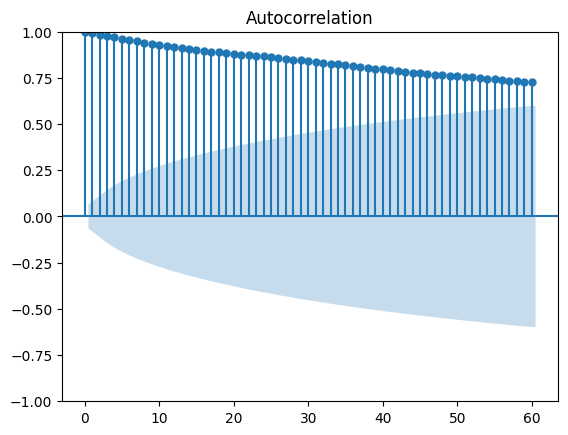

(np.float64(-1.5495851327363306), np.float64(0.5088554210747709), 2, 913, {'1%': np.float64(-3.4375326734225844), '5%': np.float64(-2.8647108493902986), '10%': np.float64(-2.568458364370556)}, np.float64(14459.164107864715))


In [29]:
# Vẽ ACF
plot_acf(df['Close'].dropna(), lags=60)
plt.show()

# 5. Kiểm định ADF
result = adfuller(df['Close'].dropna())
print(result)

p-value = 0.5088554210747709 > 0.05 => chuỗi không dừng hoặc có thể quan sát hình ra cũng biết nó không dừng :))))

---

# 3. Như hình trên ta thấy dữ liệu chưa dừng => làm dừng

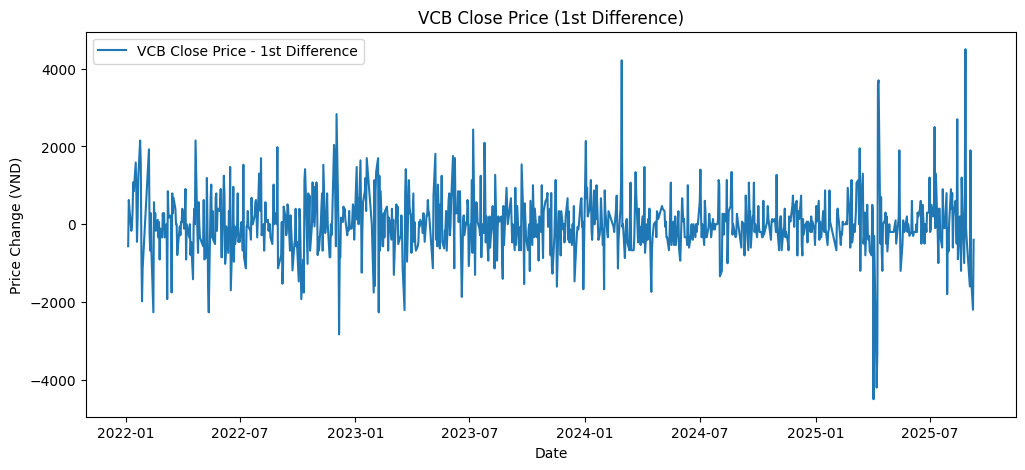

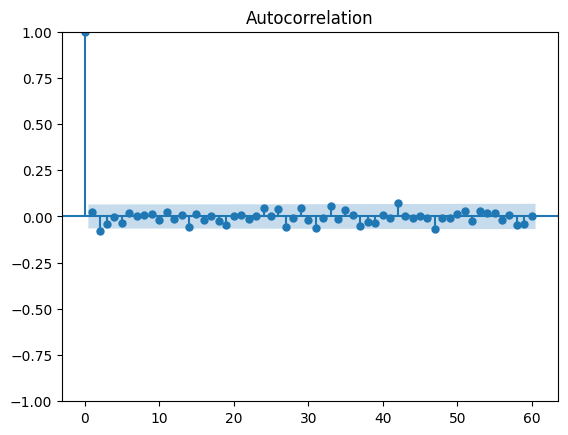

In [30]:
diff_close = df['Close'].diff().dropna()

# Vẽ dữ liệu sau khi diff
plt.figure(figsize=(12,5))
plt.plot(diff_close, label="VCB Close Price - 1st Difference")
plt.title("VCB Close Price (1st Difference)")
plt.xlabel("Date")
plt.ylabel("Price Change (VND)")
plt.legend()
plt.show()

# Vẽ ACF sau diff
plot_acf(diff_close, lags=60)
plt.show()

# Kiểm định ADF sau diff
result = adfuller(diff_close)

---

# 4. Với lag =1 hình trên thì đã kết luận không có yếu tố mùa vụ được rồi, nhưng để chắc ăn hơn thì ta vẽ thêm 'seasonal_decompose'

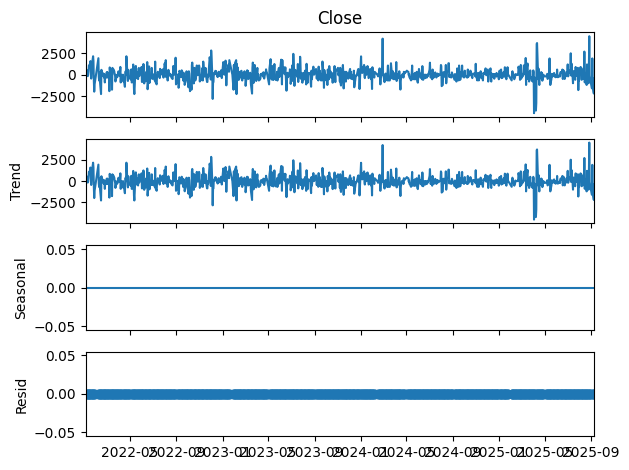

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(diff_close, period=1)
result.plot()
plt.show()

---

#5.  Kết luận: không có yếu tố mùa vụ, => dùng ARIMA

In [32]:
series = diff_close
from statsmodels.tsa.arima.model import ARIMA
order_aic_bic = []
for p in range(3):
  for q in range(3):
    model = ARIMA(series, order = (p,0,q))
    result = model.fit()
    order_aic_bic.append([p, q, result.aic, result.bic])


results_df = pd.DataFrame(order_aic_bic, columns=['p','q','AIC','BIC'])
print("Top theo AIC:")
print(results_df.sort_values('AIC').head())

print("\nTop theo BIC:")
print(results_df.sort_values('BIC').head())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Top theo AIC:
   p  q           AIC           BIC
6  2  0  14817.258707  14836.534403
7  2  1  14817.425456  14841.520077
2  0  2  14817.500019  14836.775716
5  1  2  14817.525592  14841.620213
8  2  2  14819.426926  14848.340470

Top theo BIC:
   p  q           AIC           BIC
0  0  0  14819.663195  14829.301043
1  0  1  14821.034300  14835.491073
3  1  0  14821.129240  14835.586012
6  2  0  14817.258707  14836.534403
2  0  2  14817.500019  14836.775716


---

# 6. Chốt chọn p=2 và q=0 và huấn luyện


In [33]:
model = ARIMA(series, order=(2,0,0))
result = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


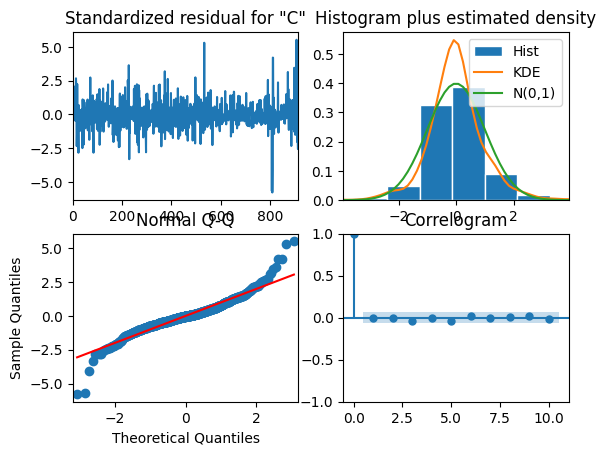

In [34]:
result.plot_diagnostics()
plt.show()

Tuy biểu đồ his chưa đẹp lắm nhưng 3 biểu đồ còn lại ok => ổn

In [35]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  915
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7404.629
Date:                Wed, 05 Nov 2025   AIC                          14817.259
Time:                        07:30:25   BIC                          14836.534
Sample:                             0   HQIC                         14824.616
                                - 915                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0283     25.129      0.877      0.381     -27.223      71.279
ar.L1          0.0260      0.022      1.191      0.234      -0.017       0.069
ar.L2         -0.0803      0.019     -4.314      0.0

---

# 7. Dự đoán

In [36]:
forecast_diff = result.get_forecast(steps=60)
forecast_values = forecast_diff.predicted_mean.cumsum() + df['Close'].iloc[-1]  # dùng cột trước khi diff(cột ở dữ liệu gốc

# Khoảng tin cậy
conf_int = forecast_diff.conf_int()
lower_ci = conf_int.iloc[:,0].cumsum() + df['Close'].iloc[-1]
upper_ci = conf_int.iloc[:,1].cumsum() + df['Close'].iloc[-1]

# Tạo index ngày cho forecast (liên tiếp theo dữ liệu gốc)
last_date = df['Close'].index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
forecast_values.index = forecast_index
lower_ci.index = forecast_index
upper_ci.index = forecast_index


# Gộp thành DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': lower_ci,
    'Upper CI': upper_ci
})

print(forecast_df)

                Forecast      Lower CI       Upper CI
2025-09-10  65089.445589  63538.009549   66640.881630
2025-09-11  65149.712527  62046.315447   68253.109607
2025-09-12  65159.294439  60499.029563   69819.559315
2025-09-13  65177.928873  58960.782824   71395.074923
2025-09-14  65200.868120  57426.810380   72974.925861
2025-09-15  65223.192578  55892.222956   74554.162201
2025-09-16  65245.155426  54357.273734   76133.037117
2025-09-17  65267.158224  52822.364461   77711.951986
2025-09-18  65289.191093  51287.485258   79290.896928
2025-09-19  65311.221538  49752.603631   80869.839445
2025-09-20  65333.249505  48217.719525   82448.779484
2025-09-21  65355.277602  46682.835550   84027.719654
2025-09-22  65377.305902  45147.951778   85606.660025
2025-09-23  65399.334196  43613.068000   87185.600392
2025-09-24  65421.362474  42078.184206   88764.540742
2025-09-25  65443.390752  40543.300412   90343.481093
2025-09-26  65465.419031  39008.416619   91922.421444
2025-09-27  65487.447311  37

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


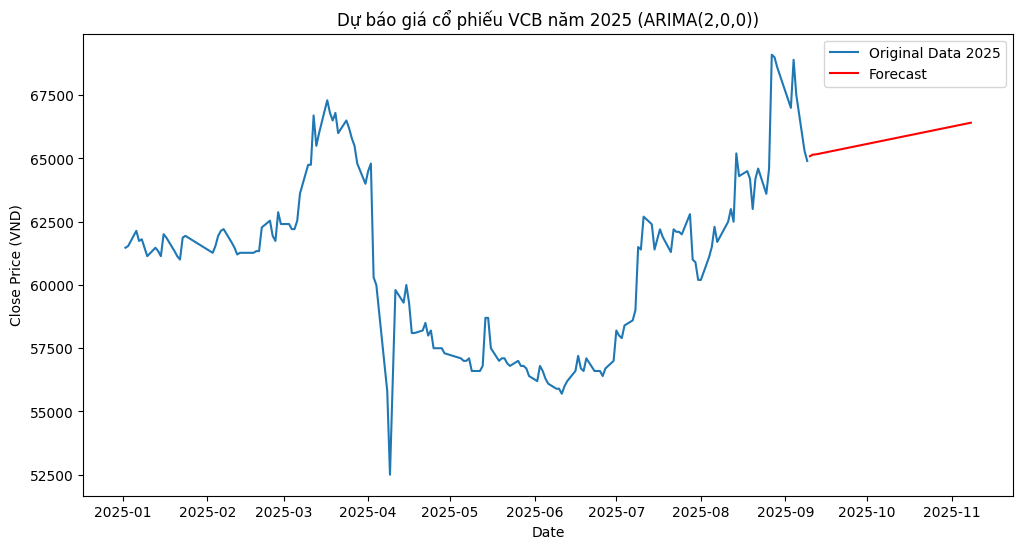

In [37]:
import matplotlib.pyplot as plt

# Lọc dữ liệu gốc cho năm 2025
df_2025 = df['2025-01-01':'2025-12-31']

# Lọc forecast nếu forecast nằm trong 2025
forecast_2025 = forecast_values[forecast_values.index.year == 2025]

plt.figure(figsize=(12,6))

# Vẽ dữ liệu gốc 2025
plt.plot(df_2025.index, df_2025['Close'], label='Original Data 2025')

# Vẽ forecast nằm trong 2025
plt.plot(forecast_2025.index, forecast_2025, label='Forecast', color='red')

plt.title('Dự báo giá cổ phiếu VCB năm 2025 (ARIMA(2,0,0))')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.show()

---

#8. Thử cắt 3 tháng cuối của dữ liệu (tháng 8,7,6) để dự đoán, xem mô hình so với thực tế ra sao

In [38]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 1. Lấy dữ liệu
df = pd.read_csv('VCB_2022_to_2025-09-10.csv')

In [39]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [40]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2022-01-04,44744.12500,44970.67578,44177.74219,44744.12500,2001830
1,2022-01-05,44177.74219,45537.05859,44177.74219,44744.12500,2987563
2,2022-01-06,44800.76172,45253.86719,44121.10547,44517.57031,2146256
3,2022-01-07,45197.22656,45253.86719,44291.01953,45083.95313,1705917
4,2022-01-10,45027.31250,45253.86719,44460.93359,45140.58984,2041027


In [41]:
df.set_index('Date', inplace=True)

In [42]:
df_train = df.loc[:'2025-05-31']
df_test = df.loc['2025-06-01':]

diff_train = df_train['Close'].diff()

# ARIMA(2,0,0) trên dữ liệu đã diff
model = ARIMA(diff_train, order=(2,0,0))
result = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [43]:
forecast_diff = result.get_forecast(steps=60)
forecast_values = forecast_diff.predicted_mean.cumsum() + df_train['Close'].iloc[-1]  # dùng cột trước khi diff(cột ở dữ liệu gốc, vd: ở đây là df_train['Close'] chứ không phải là diff_train)


# Khoảng tin cậy
conf_int = forecast_diff.conf_int()
lower_ci = conf_int.iloc[:,0].cumsum() + df['Close'].iloc[-1]
upper_ci = conf_int.iloc[:,1].cumsum() + df['Close'].iloc[-1]

# Tạo index ngày cho forecast (liên tiếp theo dữ liệu gốc)
last_date = df_train['Close'].index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
forecast_values.index = forecast_index
lower_ci.index = forecast_index
upper_ci.index = forecast_index

# In kết quả
print("Dự báo giá thực tế 30 ngày tiếp theo:")
comparison = pd.DataFrame({
    'Forecast': forecast_values,
    'Actual Test': df_test['Close'].reindex(forecast_values.index),  # gán index trùng forecast
    'Lower CI': lower_ci,
    'Upper CI': upper_ci
})
print(comparison)

Dự báo giá thực tế 30 ngày tiếp theo:
                Forecast  Actual Test      Lower CI       Upper CI
2025-05-31  56410.463901          NaN  63395.640192   66425.287610
2025-06-01  56448.994940          NaN  61918.175105   67979.814775
2025-06-02  56464.026217      56200.0  60412.647778   69515.404655
2025-06-03  56475.908429      56800.0  58903.942604   71047.874253
2025-06-04  56489.529076      56600.0  57396.949468   72582.108684
2025-06-05  56503.467695      56300.0  55890.273910   74116.661480
2025-06-06  56517.281057      56100.0  54383.472949   75651.089165
2025-06-07  56531.064290          NaN  52876.641854   77185.486726
2025-06-08  56544.856264          NaN  51369.819500   78719.893028
2025-06-09  56558.650970      55900.0  49862.999878   80254.302062
2025-06-10  56572.445091      55900.0  48356.179670   81788.710511
2025-06-11  56586.238972      55700.0  46849.359223   83323.118721
2025-06-12  56600.032890      56000.0  45342.538813   84857.526967
2025-06-13  56613.826828

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


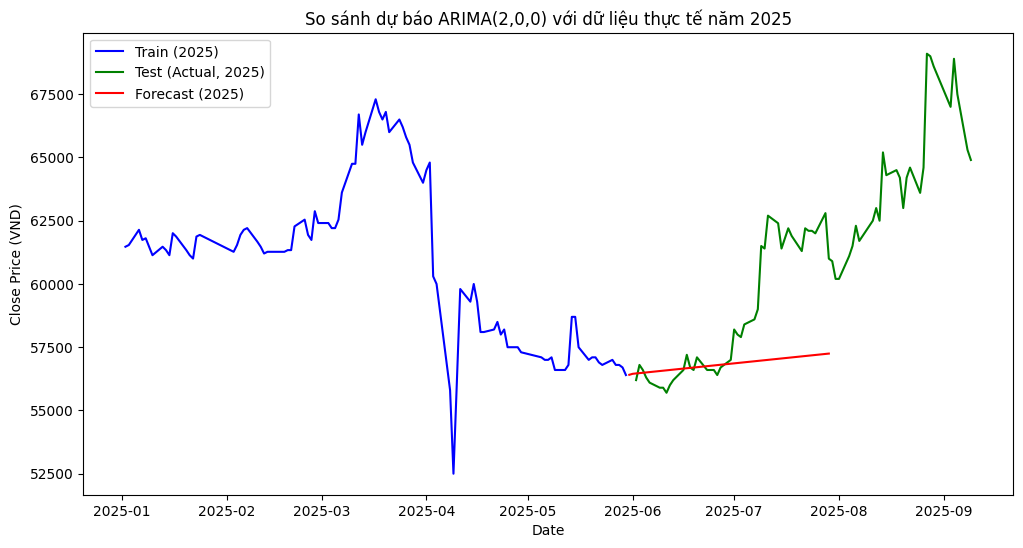

In [44]:
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu train/test trong năm 2025
df_train_2025 = df_train['2025-01-01':'2025-05-31']
df_test_2025 = df_test['2025-06-01':'2025-12-31']  # test trong năm 2025

# 2. Lọc forecast nằm trong năm 2025
forecast_2025 = forecast_values[forecast_values.index.year == 2025]

# 3. Vẽ biểu đồ
plt.figure(figsize=(12,6))

plt.plot(df_train_2025.index, df_train_2025['Close'], label='Train (2025)', color='blue')
plt.plot(df_test_2025.index, df_test_2025['Close'], label='Test (Actual, 2025)', color='green')
plt.plot(forecast_2025.index, forecast_2025, label='Forecast (2025)', color='red')

plt.title('So sánh dự báo ARIMA(2,0,0) với dữ liệu thực tế năm 2025')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.show()

---

In [45]:
train = df['2020-01-01':'2025-05-31']  # ví dụ train đến tháng 5/2025
test = df['2025-06-01':'2025-12-31']   # test từ tháng 6 đến tháng 12/2025